In [ ]:
# Author: Henrik Pettersson

In [46]:
# Standard imoprts
import numpy as np
import matplotlib.pyplot as plt

# For handling graphs and graph visualisation
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

#
from qiskit.quantum_info import SparsePauliOp
#
from qiskit.circuit.library import QAOAAnsatz

#
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#
from qiskit_aer import AerSimulator
#
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.primitives import SamplerV2 as Sampler

print('import done')

import done


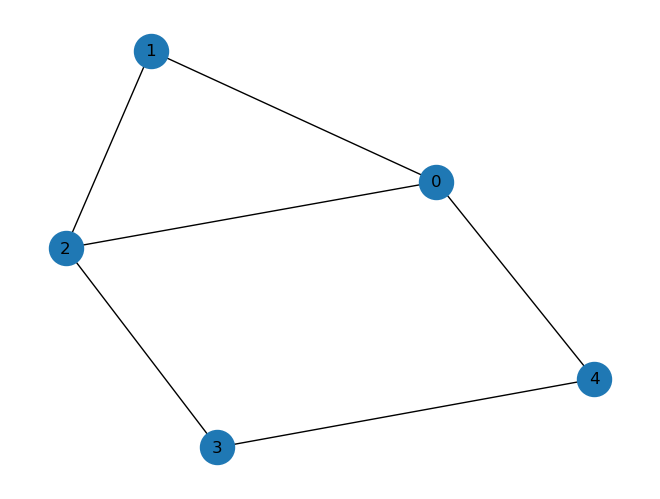

In [2]:
# Create the graph of interest for this max-cut problem

n = 5 # num of nodes in graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)] #E=(node1,node2,edgeWeight)
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [76]:
# define 'helper functions'

def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

# Estimate the cost of a given configuration
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs
    return cost

# classic maxcut evaluator
def max_cut_value(cut :str):
    value = 0
    for edge in edge_list:
        if cut[edge[0]] != cut[edge[1]]:
            value += edge[2]
    return value

In [4]:
# Create 'edge-paulis' pauli operators coresponding to measuring/cutting an edge 
max_cut_paulis = build_max_cut_paulis(graph)

# Create cost-hamiltonian from the 'edge-paulis'
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [115]:
print(max_cut_paulis)

[('IIIZZ', 1.0), ('IIZIZ', 1.0), ('ZIIIZ', 1.0), ('IIZZI', 1.0), ('IZZII', 1.0), ('ZZIII', 1.0)]


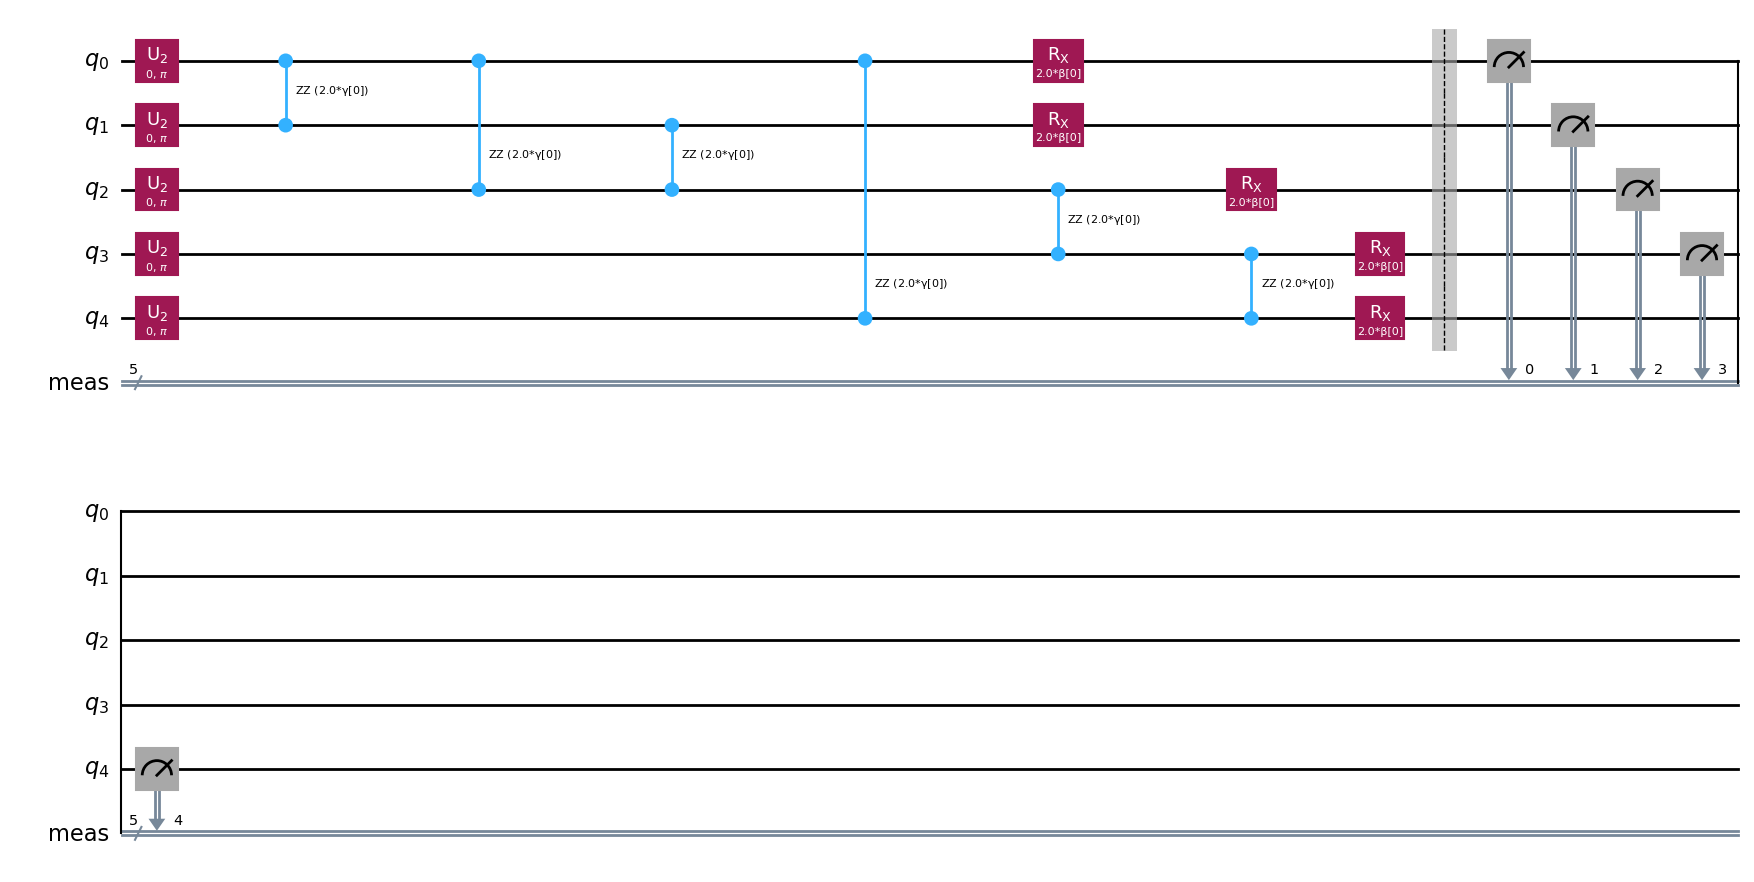

In [5]:
# Layers used in QAOA algorithm, use 1 for simple sweep,
#  more layers may give better results but reqyires more parameters and some tweeking in the code
layers=1
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
circuit.measure_all()

# Show the abstract QAOA circut
circuit.draw('mpl')

# Show the QAOA circuit in terms of simple gates
circuit.decompose().decompose().draw('mpl')

In [114]:

sim = AerSimulator()
# transpile the abstract circuit to a circuit that fit the simulator/machine
ansatz = transpile(circuit, sim, optimization_level=0)
# circuit parameters
estimator = Estimator()
hamiltonian = cost_hamiltonian

# Resolution of gamma and beta. larger number = finer resolution/more samples
# Note: aproximate time to run this cell on my machine 
# 100x100 takes ca 4317 min
# 40x40   takes ca 3 min
# 20x20   takes ca 30 sec
# 10x10   takes ca 10 sec
n_gamma = 15+2
n_beta = 15
# gamma, beta \in [0,pi] 
# Note: max-cut has a symetry so that [0, pi/2] is suficient
gammas = np.linspace(0, np.pi/2, num=n_gamma)
betas = np.linspace(0, np.pi/2, num=n_beta)

cost_values = np.zeros((n_gamma,n_beta))

# Ridiculusly high initial value to start the search for minima
# format (cost, [gamma, beta])
min_solution = (10**9,[-1,-1])

# Sweep over gamma and beta and compute the expected cost for each configuration
for ig in range(n_gamma):
    for jb in range(n_beta):
        gamma = gammas[ig]
        beta = betas[jb]
        params = [gamma, beta]#, gamma, beta]
        cost_values[ig,jb] = cost_func_estimator(params, ansatz, hamiltonian, estimator)
        
        # keep track of minimal solutions for later
        if cost_values[ig,jb] < min_solution[0]:
            min_solution = (cost_values[ig,jb],params)

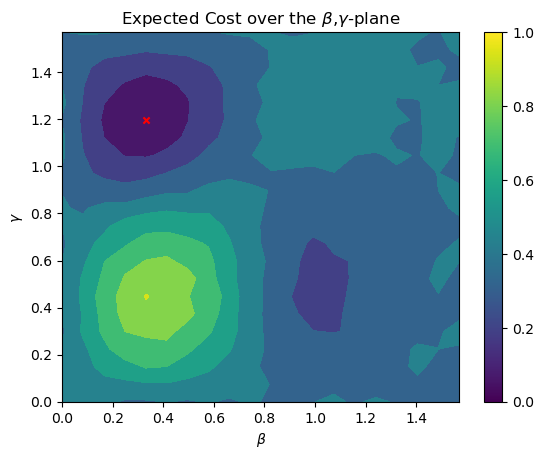

In [ ]:
#plotting The result

# plot Contours of the expected cost function in the beta gamma plane
# lower values corespond to a better solution
plt.contourf(betas, gammas, cost_values)
cost_min = min_solution[0]
gamma_min,beta_min = min_solution[1]
plt.scatter(beta_min,gamma_min, s=20, c='red',marker='x')
#ax.set_xlim(0, np.pi)
#ax.set_ylim(0, np.pi)

plt.colorbar()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
plt.title(r'Expected Cost over the $\beta$,$\gamma$-plane')

plt.show()

In [ ]:
# Run the optimal configuration found above
sampler = Sampler()
params_min = [gamma_min,beta_min]

isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
# pub = (ansatz, isa_hamiltonian, params_min)
# job = sampler.run([pub])
# results = job.result()[0]
# cost = results.data.evs

########
 
measured_circuit = ansatz
 
noisy_sampler = Sampler()
shots = None # None gives a better distribution estimarion than a small arbitrary number
# The circuit needs to be transpiled to the AerSimulator target

pub = (ansatz, params_min, shots)
job = noisy_sampler.run([pub])
result = job.result()
pub_result = result[0]
result_distribution :dict = pub_result.data.meas.get_counts()


Text(0, 0.5, 'Frequency [%]')

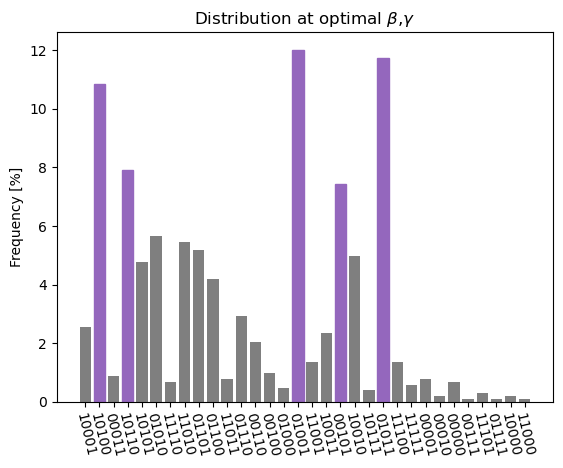

In [142]:
total_val = 0
for item in result_distribution.values():
    total_val += item
freqs_percent = {name:100*value/total_val for name,value in result_distribution.items()}
bit_string = list(freqs_percent.keys())
counts = list(freqs_percent.values())

top_5_values = sorted(counts, reverse=True)[:5]

positions = []
for i in range(len(counts)) :
    if counts[i] > 7:
     positions.append(i)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(bit_string,freqs_percent.values(),color="tab:grey")
for p in positions:
    ax.get_children()[p].set_color("tab:purple")


# Rotating X-axis labels
plt.xticks(rotation = -77)
plt.title(r'Distribution at optimal $\beta$,$\gamma$')
plt.ylabel('Frequency [%]')

In [ ]:
#plt.hist(result_distribution)

# extract the top 5 values
n = 5
top_n_values=[] #(key,freq)


for item in result_distribution.items():

    top_n_values.append(item)
   
    top_n_values = sorted(top_n_values,key=lambda item: item[1], reverse = True)
    
    if len(top_n_values) > n:
        top_n_values.pop()

top = top_n_values[0]

top_n_cuts = [[],[]]
for cut, _ in top_n_values:
    top_n_cuts[0].append(cut)
    top_n_cuts[1].append(max_cut_value(cut))


4.0

Text(0, 0.5, 'Value of solution')

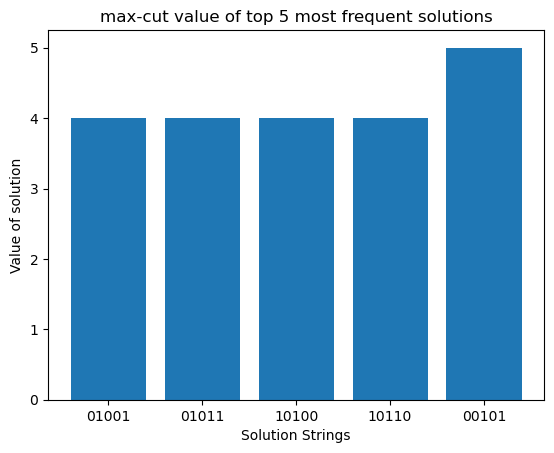

In [ ]:
plt.bar(top_n_cuts[0],top_n_cuts[1])

plt.title('max-cut value of top 5 most frequent solutions')
plt.xlabel('Solution Strings')
plt.ylabel('Value of solution')